# Social Network Mapping: Spotify
## Background and Requirements

This tutorial focuses on demostrating how to perform social network analysis using the Spotify API. Social networks can reveal patterns, connections and structures within networks of interactions, such as music collaborations or shared preferences among users. In this tutorial we will explore two networks:
1. Artist collaboration network.
2. User song sharing network.

### Objectives
- Learn how to obtain and use credentials for the Spotify API.
- Extract relevant data using Spotify's Web API.
- Construct and analyze two types of social networks using Python libraries.
- Visualize the networks to interpret the relationships and insights.

### Tools and Libraries
- Spotipy: A lightweight Python library for the Spotify Web API. It handles requests and authentication.
- NetworkX: Used for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
- Matplotlib: A plotting library for creating static, interactive, and animated visualizations in Python.
- Pandas: Essential for data manipulation and analysis.
- Requests: Allows sending HTTP requests in Python, useful for handling API calls.

### Setting Up Spotify API Access
**Prerequisites:** Have an active Spotify account.

Steps:
1. Create a Spotify developer account:
https://developer.spotify.com/
  - Press log in.
  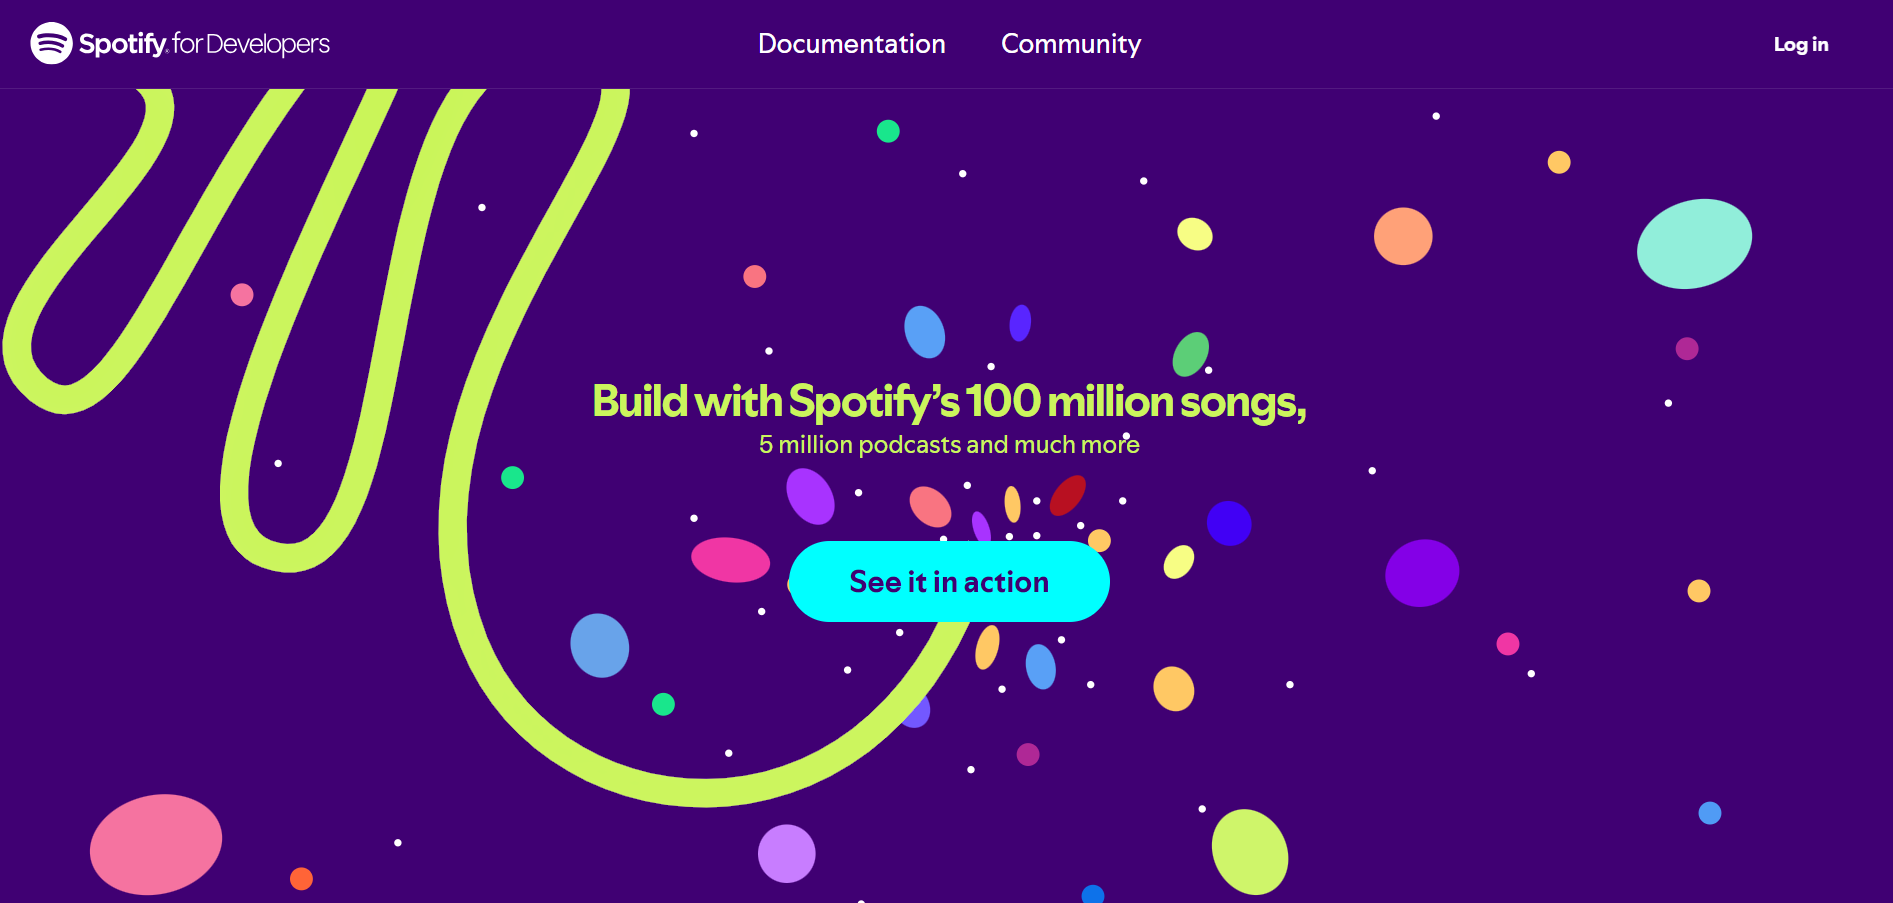

  - Log into your Spotify account.
  - Go to your dashboard.
  
  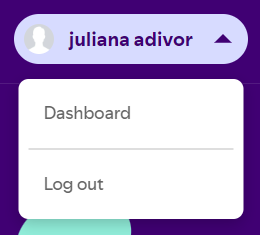
  - Accept Spotify Developer Terms.
  - Verify your email address, if necessary.
  - Create app to obtain your ID and secret key.
  - Put a name to your app, in this case, we will use Social Network Analysis
  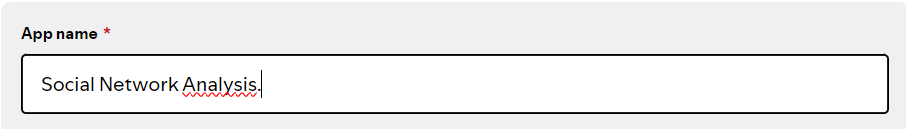
  - Describe your app.
  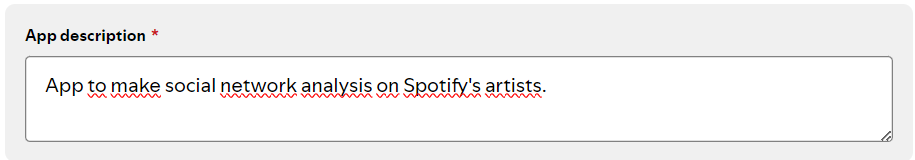
  - If your app has a website, put the url, else you can leave this space white.
  - In Redirect URIs we will put http://localhost:8888/callback as example.
  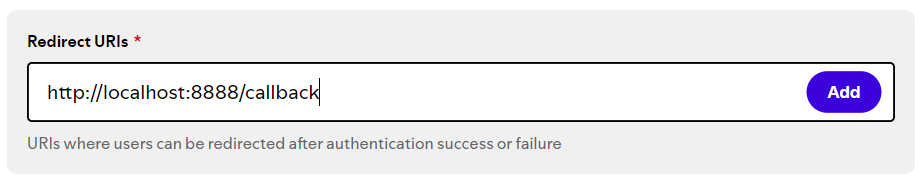
  - Select which API/SDKs are you planning to use, in this case, we will use Web API only.
  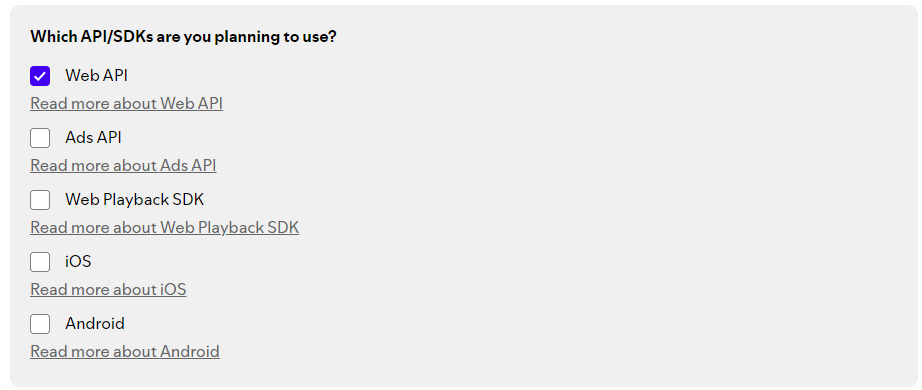
  - Accept terms of service and guidelines.
  - Save your app.
  - In the home menu of your app, click on settings.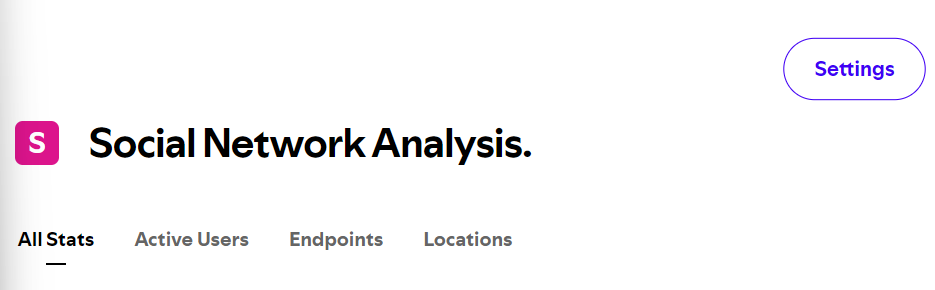
  - Save your client ID and your secret key in a save place, it is important to not to lose it and do not share the secret key.
  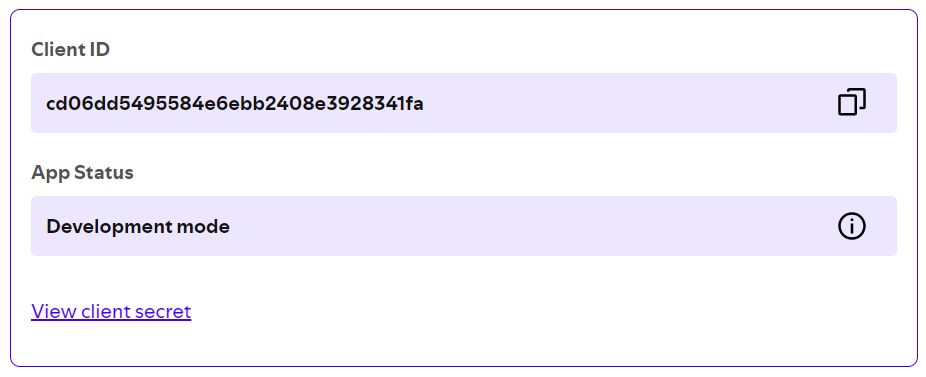
  - Now you have your credentials.

### Limitations and Considerations
- Rate Limits: Spotify imposes rate limits on API requests, which can affect how much data you can fetch in a given period.
- Data Accessibility: Not all user data is accessible due to privacy restrictions; for example, we can only access songs that users have saved in playlists, not songs they've liked.

## Mapping a Social Network

### Setting Up
Before starting, you'll need to install the necessary Python libraries.

In [3]:
!pip install spotipy networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/252.1 kB 7.2 MB/s eta 0:00:00


Next, import the required libraries:

In [4]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import requests

### Artist Collaboration Network

First, authenticate using your Spotify Developer credentials. The `spotipy.Spotify` object works as authentication mechanism and it is used to access to publicly available information, such as retrieving information about artists, albums, and tracks.

Replace `your_client_id` and `your_client_secret` with the credentials you obtained from the Spotify Developer Dashboard:

In [6]:
# Replace these with your actual Spotify Developer credentials
client_id = 'CLIENT_ID'
client_secret = 'CLIENT_SECRET'

# Authenticate using your Spotify Developer credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

The first step in building our network is to retrieve data on the top artists in a determined country. We define a function get_top_artists_in_country that uses the Spotify API to fetch these artists based on popularity.

In this example, we will Mexico's top artist from this year.



In [22]:
# Define a function to fetch top artists from Spotify based on year and market.
def get_top_artists_country(year, market, total=100):
    artist_data = [] # Initialize an empty list to store artist information.
    limit = 50  # Set the maximum number of results per API call to 50.

     # Create a query string that includes the specified year.
    query = f'year:{year}'

    # Loop through the results in batches of 'limit' until reaching the 'total' number of artists.
    for offset in range(0, total, limit):
        # Call the Spotify search API with the year query, specifying artist type, market, and pagination.
        results = sp.search(q=query, type='artist', market=market, limit=limit, offset=offset)
        # Extract artist items from the API response.
        artists = results['artists']['items']

         # Loop through each artist in the current batch.
        for artist in artists:
             # Create a dictionary containing key details about each artist.
            artist_info = {
                'Name': artist['name'],
                'ID': artist['id'],
                'Popularity': artist['popularity'],
                'Genres': ', '.join(artist['genres']),
                'Followers': artist['followers']['total']
            }
            # Append the artist info to the list of artist data.
            artist_data.append(artist_info)

    # Return the collected artist data, limited to the number specified by 'total'.
    return artist_data[:total]

# Use the function to fetch the top artists in Mexico for the year 2024.
top_artists = get_top_artists_country(year=2024, market='MX')

# Convert the list of dictionaries into a DataFrame for better visualization and analysis.
df_top_artists = pd.DataFrame(top_artists)

# Display the DataFrame showing the top artists.
df_top_artists

,Name,ID,Popularity,Genres,Followers
0,Peso Pluma,12GqGscKJx3aE4t07u7eVZ,91,"corridos tumbados, sad sierreno",15077023
1,Junior H,7Gi6gjaWy3DxyilpF1a8Is,89,"corrido, corridos tumbados, musica mexicana, s...",17433009
2,Natanael Cano,0elWFr7TW8piilVRYJUe4P,88,"corrido, corridos tumbados, musica mexicana, s...",13861604
3,Bad Bunny,4q3ewBCX7sLwd24euuV69X,94,"reggaeton, trap latino, urbano latino",83851618
4,Carin Leon,66ihevNkSYNzRAl44dx6jJ,86,"corrido, musica mexicana, sad sierreno, sierreno",12096587
...,...,...,...,...,...
95,Humbe,1b7AEdUSudOQoZF5ebUxCL,73,"monterrey indie, urbano mexicano",1587152
96,Calvin Harris,7CajNmpbOovFoOoasH2HaY,87,"dance pop, edm, electro house, house, pop, pop...",22673988
97,Los Bukis,16kOCiqZ1auY4sokSeZuKf,74,"grupera, gruperas inmortales, musica mexicana",4212087
98,Aventura,1qto4hHid1P71emI6Fd8xi,80,"bachata, bachata dominicana, latin hip hop, la...",8202334


Next, we identify collaborations between these artists. We look for tracks that feature multiple top artists:

In [26]:
# Define a function to find collaborations among a list of artists.
def get_collaborations(artists, country):
    collaborations = []  # Initialize an empty list to store collaboration details.

    # Create a dictionary mapping artist IDs to their names for quick lookup.
    artist_ids = {artist['ID']: artist['Name'] for artist in artists}

    # Iterate over each artist in the provided list.
    for artist in artists:
        # Retrieve the top tracks of the artist in the specified market.
        results = sp.artist_top_tracks(artist['ID'], country=country)

        # Iterate over each track in the top tracks of the artist.
        for track in results['tracks']:
            # Extract the IDs of all artists involved in the track.
            track_artists = [a['id'] for a in track['artists']]

            # Find the intersection of track artists with the list of top artists' IDs.
            # This identifies tracks that feature collaborations between top artists.
            common_artists = set(track_artists).intersection(artist_ids.keys())

            # If there is more than one top artist on the track, it's a collaboration.
            if len(common_artists) > 1:
                # Create a dictionary with details about the collaboration.
                collaboration_info = {
                    'Track Name': track['name'],  # Name of the track
                    'Artists': ', '.join([artist_ids[aid] for aid in common_artists]),  # Names of the artists collaborating
                    'Track URL': track['external_urls']['spotify']  # URL to the track on Spotify
                }
                # Append the collaboration info to the list.
                collaborations.append(collaboration_info)

    # Return the list of collaborations.
    return collaborations

# Use the function to find collaborations among the top artists.
collaborations = get_collaborations(top_artists, 'MX')

# Convert the list of collaborations into a DataFrame for better visualization and analysis.
df_collaborations = pd.DataFrame(collaborations)

# Display the DataFrame showing the collaborations.
df_collaborations

,Track Name,Artists,Track URL
0,QLONA,"KAROL G, Peso Pluma",https://open.spotify.com/track/5RqSsdzTNPX1uzk...
1,LA PATRULLA,"Neton Vega, Peso Pluma",https://open.spotify.com/track/2aYZaN5SmkRDLsr...
2,VINO TINTO,"Natanael Cano, Gabito Ballesteros, Peso Pluma",https://open.spotify.com/track/5UHK1rtK4MpBGb0...
3,TOMMY & PAMELA,"Kenia OS, Peso Pluma",https://open.spotify.com/track/3GWUv0TDO5E3cHf...
4,LA DURANGO,"Eslabon Armado, Peso Pluma, Junior H",https://open.spotify.com/track/5jVExEArvISIYu8...
...,...,...,...
270,We Found Love,"Calvin Harris, Rihanna",https://open.spotify.com/track/0U10zFw4GlBacOy...
271,This Is What You Came For,"Calvin Harris, Rihanna",https://open.spotify.com/track/0azC730Exh71aQl...
272,One Kiss (with Dua Lipa),"Calvin Harris, Dua Lipa",https://open.spotify.com/track/7ef4DlsgrMEH11c...
273,Ella Y Yo - Featuring Don Omar,"Don Omar, Aventura",https://open.spotify.com/track/6G4U9avyBNEfP0f...


Finally, we visualize the collaboration network using NetworkX and Matplotlib:

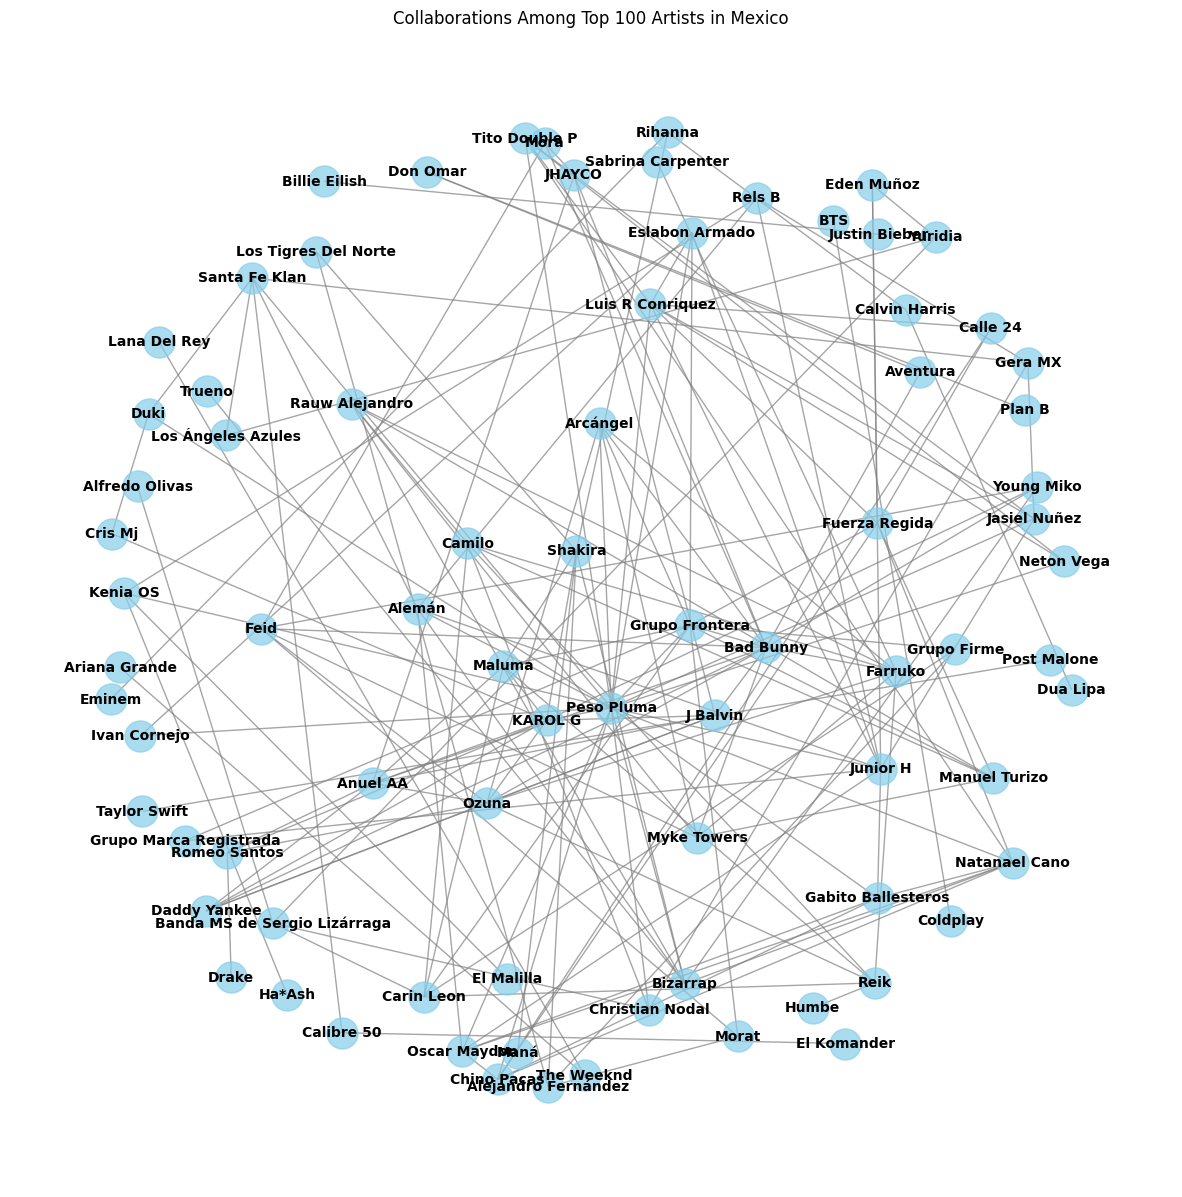

In [58]:
# Define a function to create and visualize a graph of artist collaborations.
def create_collaboration_graph(df_collaborations):
    G = nx.Graph()  # Initialize a new graph. Use a simple graph where each edge is undirected and connects two nodes (artists).

    # Add edges to the graph based on collaboration data from the DataFrame.
    for _, row in df_collaborations.iterrows():
        artists = row['Artists'].split(', ')  # Split the string of artist names into a list.
        # Create edges between all pairs of collaborating artists in this track.
        for i in range(len(artists)):
            for j in range(i + 1, len(artists)):
                G.add_edge(artists[i], artists[j])  # Add an edge between each pair of artists.

    # Plot the graph using matplotlib.
    plt.figure(figsize=(15, 15))  # Set the size of the plot.
    pos = nx.spring_layout(G, k=1.5, seed=30)  # Position nodes using the spring layout algorithm, which helps visualize the graph clearly.
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', alpha=0.7)  # Draw the nodes (artists) in sky blue.
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color='gray')  # Draw the edges (collaborations) in gray.
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')  # Label the nodes with artist names.

    plt.title("Collaborations Among Top 100 Artists in Mexico")  # Set the title of the plot.
    plt.axis('off')  # Turn off the axis since they are not relevant in this context.
    plt.show()  # Display the plot.
    return G

# Create and plot the graph based on the DataFrame 'df_collaborations'
G = create_collaboration_graph(df_collaborations)

Now that we have our network, we can analyze the characteristics of it:

In [59]:
# Check if the graph is connected
if nx.is_connected(G):
    # Calculate key network metrics if the graph is fully connected
    avg_path_length = nx.average_shortest_path_length(G)  # Average number of steps along the shortest paths for all possible pairs of network nodes
    clustering_coefficient = nx.average_clustering(G)  # Measure of the degree to which nodes in a graph tend to cluster together
    diameter = nx.diameter(G)  # The largest number of vertices that must be traversed in order to travel from one vertex to another
    eccentricity = nx.eccentricity(G)  # The maximum distance from a node to all other nodes in the graph
    radius = nx.radius(G)  # The minimum eccentricity among the vertices
    periphery = nx.periphery(G)  # Set of nodes that have eccentricity equal to the diameter
    center = nx.center(G)  # Set of nodes that have eccentricity equal to the radius
else:
    print('Graph is not connected, calculating metrics for largest connected component')
    # Calculate metrics for the largest connected component if the graph is not fully connected
    largest_cc = max(nx.connected_components(G), key=len)  # Find the largest connected component
    G_largest_cc = G.subgraph(largest_cc)  # Create a subgraph of G based on the largest connected component
    # Calculate metrics for the largest connected component
    avg_path_length = nx.average_shortest_path_length(G_largest_cc)
    clustering_coefficient = nx.average_clustering(G_largest_cc)
    diameter = nx.diameter(G_largest_cc)
    eccentricity = nx.eccentricity(G_largest_cc)
    radius = nx.radius(G_largest_cc)
    periphery = nx.periphery(G_largest_cc)
    center = nx.center(G_largest_cc)

# Retrieve the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Calculate the average distance across the graph (or its largest connected component if not fully connected)
avg_distance = nx.average_shortest_path_length(G_largest_cc) if not nx.is_connected(G) else avg_path_length

# Prepare a dictionary to store all the calculated network characteristics
network_characteristics = {
    'Number of nodes': num_nodes,
    'Number of edges': num_edges,
    'Average path length': avg_path_length,
    'Clustering coefficient': clustering_coefficient,
    'Diameter': diameter,
    'Eccentricity': eccentricity,
    'Radius': radius,
    'Periphery': periphery,
    'Center': center,
    'Average distance': avg_distance
}

# Print each characteristic with its calculated value
for characteristic, value in network_characteristics.items():
    print(f"{characteristic}: {value}")

Graph is not connected, calculating metrics for largest connected component
Number of nodes: 80
Number of edges: 168
Average path length: 3.294567404426559
Clustering coefficient: 0.26251319309139914
Diameter: 9
Eccentricity: {'KAROL G': 5, 'Peso Pluma': 5, 'Neton Vega': 6, 'Natanael Cano': 6, 'Gabito Ballesteros': 6, 'Kenia OS': 6, 'Eslabon Armado': 6, 'Junior H': 6, 'Tito Double P': 6, 'Oscar Maydon': 6, 'Rels B': 7, 'Bizarrap': 5, 'Bad Bunny': 6, 'Myke Towers': 6, 'Feid': 6, 'J Balvin': 5, 'Grupo Frontera': 5, 'JHAYCO': 6, 'Maluma': 5, 'Carin Leon': 5, 'Camilo': 6, 'Banda MS de Sergio Lizárraga': 6, 'Fuerza Regida': 6, 'Calle 24': 7, 'Chino Pacas': 6, 'Manuel Turizo': 6, 'Luis R Conriquez': 6, 'Jasiel Nuñez': 6, 'Shakira': 6, 'Romeo Santos': 5, 'Young Miko': 5, 'Ozuna': 5, 'Grupo Firme': 5, 'Alfredo Olivas': 7, 'Alejandro Fernández': 6, 'Christian Nodal': 6, 'Yuridia': 7, 'Rihanna': 7, 'Gera MX': 7, 'Grupo Marca Registrada': 6, 'Anuel AA': 5, 'Trueno': 6, 'Rauw Alejandro': 5, 'Cris 

The network analysis has revealed several key metrics of our network, but look, the network for Mexico, is not connected, and to calculate the metrics, the largest connected component was used. Thanks to this analyzis we have the following insights of our network:
- The average path length is approximately 3.294, which means that, on average, any artist is about three steps away from another artist in this component of the network.

- The diameter of the network is 9. This is the longest shortest path between any two nodes in the network. It indicates the maximum distance that separates any two artists.

<ipython-input-55-faa868d45742>:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Betweenness Centrality')


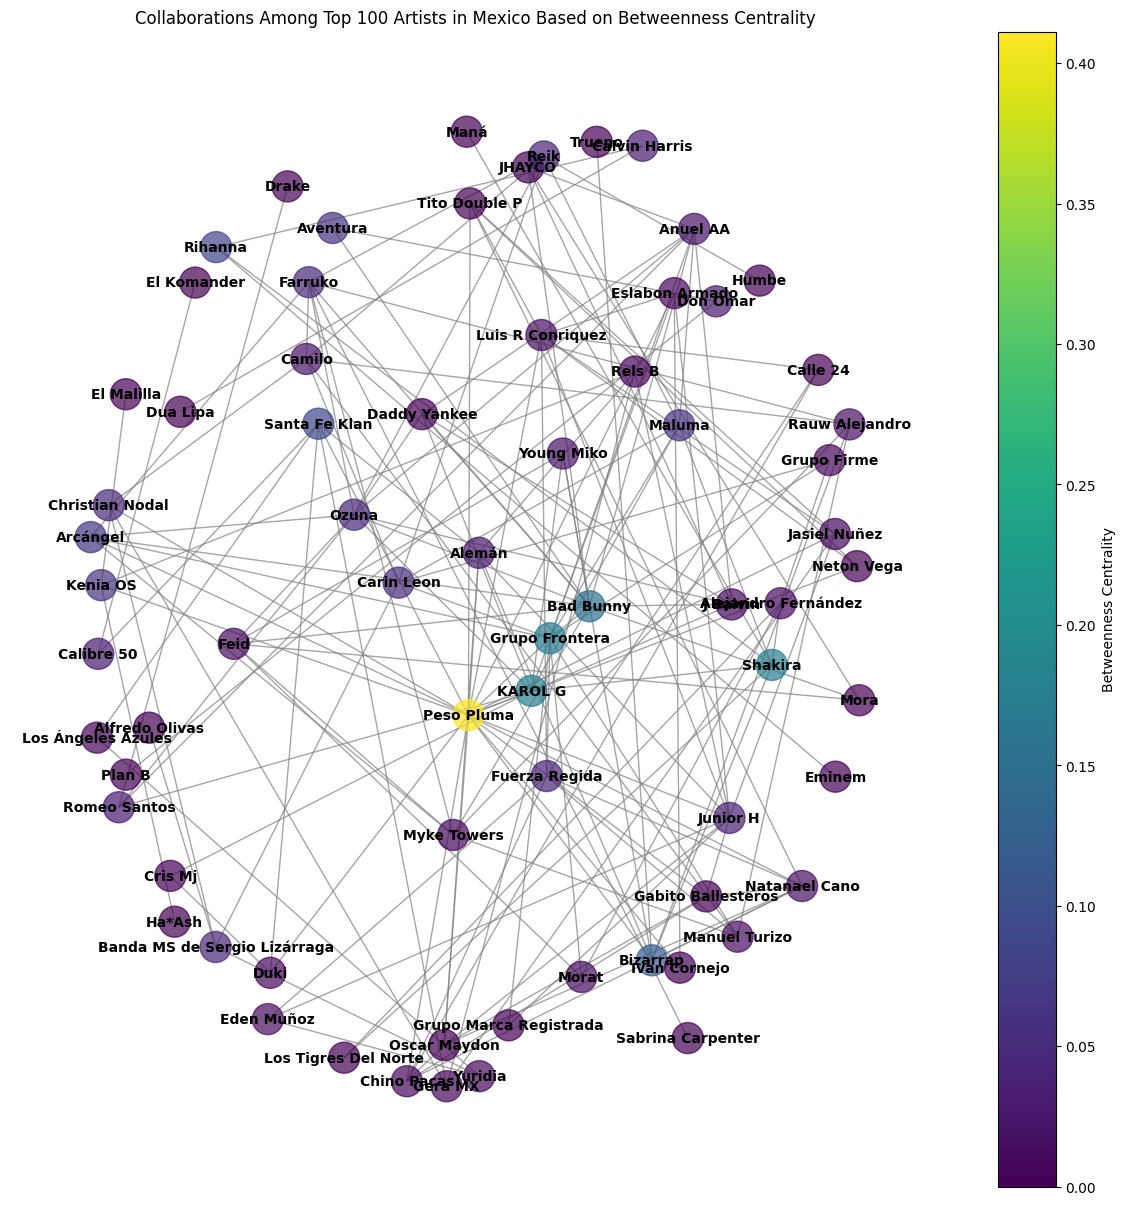

In [55]:
# Calculate betweenness centrality for each node in the largest connected component.
betweenness_centrality = nx.betweenness_centrality(G_largest_cc)

# Choose a colormap for visual representation of node metrics.
cmap = plt.colormaps['viridis']

# Normalize betweenness centrality values for color mapping. This sets a scale from the minimum to the maximum value of betweenness centrality.
norm = mcolors.Normalize(vmin=min(betweenness_centrality.values()), vmax=max(betweenness_centrality.values()))

# Assign colors to each node based on their normalized betweenness centrality values. This helps to visually differentiate nodes based on their centrality.
node_colors = [cmap(norm(betweenness_centrality[node])) for node in G_largest_cc.nodes()]

# Plot the graph using matplotlib.
plt.figure(figsize=(15, 15))  # Set the size of the plot.
pos = nx.spring_layout(G_largest_cc, k=1.5, seed=30)  # Position nodes using the spring layout algorithm, which helps visualize the graph clearly.
nx.draw_networkx_nodes(G_largest_cc, pos, node_size=500, node_color=node_colors, alpha=0.7)  # Draw the nodes (artists) in sky blue.
nx.draw_networkx_edges(G_largest_cc, pos, width=1.0, alpha=0.7, edge_color='gray')  # Draw the edges (collaborations) in gray.
nx.draw_networkx_labels(G_largest_cc, pos, font_size=10, font_weight='bold')  # Label the nodes with artist names.

plt.title("Collaborations Among Top 100 Artists in Mexico Based on Betweenness Centrality")  # Set the title of the plot.
plt.axis('off')  # Turn off the axis since they are not relevant in this context.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Betweenness Centrality')
plt.show()

## Users song sharing network

This section of the tutorial demonstrates how to construct a network graph based on shared songs between users' playlists on Spotify.

For this graph, we will use the `requests` library to interact directly with endpoints that require user-specific data, such as playlists and tracks.

Using the `requests` library directly gives us more control over the HTTP requests, allowing for custom headers, direct error handling, and specific data extraction from the JSON responses tailored to our needs.

First, to access user-specific data on Spotify, we need to authenticate our requests using an access token obtained from Spotify's API.



In [30]:
# Function to get an access token from Spotify API
def get_spotify_token(client_id, client_secret):
    # URL to Spotify's API token service
    url = 'https://accounts.spotify.com/api/token'
    # Headers to send with the request, indicating the expected content type
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
     # Data payload for the post request, specifying the grant type
    data = {'grant_type': 'client_credentials'}

    # Make a POST request to the Spotify accounts service to get the token.
    # The auth parameter is used for basic HTTP authentication with the client ID and client secret.
    response = requests.post(url, headers=headers, data=data, auth=(client_id, client_secret))

    # Parse the JSON response and return the access token.
    # The .get method on the response's JSON output safely returns the access token or None if not present.
    return response.json().get('access_token')

# Obtain the token using the get_spotify_token function
token = get_spotify_token(client_id, client_secret)

# Print the token to verify it was successfully retrieved
token

'BQCkSxCN7RvgbnhwsKQ0TkUtZXg7-mvRLNrD5_DhwmyK7BKUYd2Kja7uSFARq-0oeTGqqPdHTCemPow2NfRaMETr6y5h0WU1P6Q-02hPWANmuPt3qxI'

We will define a function to fetch all playlists owned by a user.

In [55]:
# Define a function to fetch the playlists of a specific Spotify user.
def get_user_playlists(user_id, token):
    # Construct the URL for the API request using the user ID.
    url = f'https://api.spotify.com/v1/users/{user_id}/playlists'

    # Set up the headers with the authorization token to ensure the request is authenticated.
    headers = {'Authorization': f'Bearer {token}'}

    # Make a GET request to the Spotify API to fetch the playlists.
    response = requests.get(url, headers=headers)

    # Check the status code of the response to determine if the request was successful.
    if response.status_code == 200:
        # If the request was successful, return the list of playlists.
        return response.json().get('items', [])
    else:
        # If the request failed, print an error message with the status code and return an empty list.
        print(f"Failed to get playlists for user {user_id}. Status code: {response.status_code}")
        return []

# Example user ID to demonstrate how to use the function.
example_user_id = '12185787285'

# Retrieve playlists using the user ID and token.
playlists = get_user_playlists(example_user_id, token)
playlists[40]

{'collaborative': False,
 'description': '',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/5uimpum9TtYYIsrMGkHCRS'},
 'href': 'https://api.spotify.com/v1/playlists/5uimpum9TtYYIsrMGkHCRS',
 'id': '5uimpum9TtYYIsrMGkHCRS',
 'images': [{'height': None,
   'url': 'https://image-cdn-ak.spotifycdn.com/image/ab67706c0000da84a31567b070d4e64d59ecff6d',
   'width': None}],
 'name': '2024; 二四',
 'owner': {'display_name': 'Juliana Ramayo Cardoso',
  'external_urls': {'spotify': 'https://open.spotify.com/user/12185787285'},
  'href': 'https://api.spotify.com/v1/users/12185787285',
  'id': '12185787285',
  'type': 'user',
  'uri': 'spotify:user:12185787285'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'AAABQ1dysBQCQDnRSh/pK8ffgYlfCCmI',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/5uimpum9TtYYIsrMGkHCRS/tracks',
  'total': 412},
 'type': 'playlist',
 'uri': 'spotify:playlist:5uimpum9TtYYIsrMGkHCRS'}

Next, we define a function to get a sample of tracks of a specific playlist. This will help us later to determine shared songs between users.

In [58]:
# Define a function to fetch tracks from a specific Spotify playlist, including artist names.
def get_playlist_tracks(playlist_id, token):
    # Construct the URL for the API request using the playlist ID.
    url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'

    # Set up the headers with the authorization token to ensure the request is authenticated.
    headers = {'Authorization': f'Bearer {token}'}

    # Make a GET request to the Spotify API to fetch the playlist tracks.
    response = requests.get(url, headers=headers)

    # Check the status code of the response to determine if the request was successful.
    if response.status_code == 200:
        # Parse the JSON response to get a list of track items.
        items = response.json().get('items', [])
         # Extract track names and corresponding artist names, ensuring no None values are included.
        tracks = [(item['track']['name'], ", ".join(artist['name'] for artist in item['track']['artists'] if artist['name'] is not None))
                  for item in items if item and 'track' in item and item['track'] and item['track']['name'] is not None]
        return tracks
    else:
        # If the request failed, print an error message with the status code and return an empty list.
        print(f"Failed to get tracks for playlist {playlist_id}. Status code: {response.status_code}")
        return []

# Example playlist ID to demonstrate how to use the function.
example_playlist_id = '5uimpum9TtYYIsrMGkHCRS'
# Retrieve tracks using the playlist ID and token.
tracks = get_playlist_tracks(example_playlist_id, token)
tracks

[('Fuck it I love you', 'Lana Del Rey'),
 ('Come Clean', 'Hilary Duff'),
 ('Honey', 'THE BOYZ'),
 ('WATCH IT', 'THE BOYZ'),
 ('Respuesta Cero', 'Quevedo, BlueFire'),
 ('911', 'Sech'),
 ('CALL ME MAYBE', 'Duki'),
 ('Peligro', 'Reik'),
 ('Daydreamer', 'Adele'),
 ('I Think We Should Stay in Love', 'Jesse®'),
 ('SOS (Prod. Marshmello)', 'SEVENTEEN'),
 ('Cover Me', 'Stray Kids'),
 ('COMFLEX', 'Stray Kids'),
 ('BLIND SPOT', 'Stray Kids'),
 ('LALALALA', 'Stray Kids'),
 ('MEGAVERSE', 'Stray Kids'),
 ('Headliner', 'SEVENTEEN'),
 ('Yawn', 'SEVENTEEN'),
 ('Back 2 Back', 'SEVENTEEN'),
 ('Diamond Days', 'SEVENTEEN'),
 ('Don’t Delete The Kisses', 'Wolf Alice'),
 ('MEMORIAS', 'Mora, JHAYCO'),
 ('Muchachitos Feat. Humbe', 'Juliana, Humbe'),
 ('Something That I Want', 'Grace Potter'),
 ('ecstacy', 'SUICIDAL-IDOL'),
 ('ecstacy (slowed)', 'SUICIDAL-IDOL'),
 ('Babydoll', 'Dominic Fike'),
 ('LALALALA (Rock Ver.)', 'Stray Kids'),
 ('Social Path (Feat. LiSA) (Korean Ver.)', 'Stray Kids, LiSA'),
 ('Leave', 'S

This function compares the tracks from the playlists of each pair of users to find mutual songs. It maps these songs to the relationships between users, which will form the edges of our network graph.

In [62]:
# Define a function to find mutual songs between a list of Spotify users.
def find_mutual_songs(user_ids, token):
    user_tracks = {} # Initialize a dictionary to store tracks by user ID.

    # Iterate over each user ID in the provided list.
    for user_id in user_ids:
        playlists = get_user_playlists(user_id, token) # Fetch playlists for the user.
        tracks = [] # Initialize a list to collect tracks from all playlists.
        # Iterate over each playlist and collect tracks.
        for playlist in playlists:
            tracks.extend(get_playlist_tracks(playlist['id'], token))
        # Store the unique tracks for each user in a set to avoid duplicates and allow easy comparison.
        user_tracks[user_id] = set(tracks)

    mutual_songs = {} # Initialize a dictionary to store mutual songs between users.
    # Compare tracks between every pair of users to find mutual songs.
    for user1 in user_ids:
        for user2 in user_ids:
            if user1 != user2: # Ensure we are not comparing a user with themselves.
                mutual = user_tracks[user1].intersection(user_tracks[user2])  # Find intersection of their track sets.
                mutual_songs[(user1, user2)] = mutual # Store the mutual songs under a tuple of both user IDs.

    return mutual_songs # Return the dictionary containing pairs of users and their mutual songs.

# Example user IDs to demonstrate how to use the function (replace these with other Spotify user IDs).
USER_IDS = ['12185787285', '22ybsu7ffjt2seqmnuqvwlidi', 'fnyr6g0m6shl4z4ji24w0h59x', "31amgnhbdkl3jc43n3n5stn3nslq",  "31iazkin6kvepulxj7vgevz4wi5a", "4pssupc9bg2z5dynkyhgt3wk2", 'l8q1aktv3ejmylsok7ow49vzy', '21fx3xnfaf4dsjrkfpgqtsxpq']
mutual_songs = find_mutual_songs(USER_IDS, token)
mutual_songs

{('12185787285',
  '22ybsu7ffjt2seqmnuqvwlidi'): {('No Me Digas Que No ( Boy Like You )',
   'Nikki Clan'), ('Odio Amarte', 'Ha*Ash'), ('Por Ti',
   'Belanova'), ('Qué Vida la Mía', 'Reik'), ('Te quiero', 'Hombres G')},
 ('12185787285',
  'fnyr6g0m6shl4z4ji24w0h59x'): {('1 step forward, 3 steps back',
   'Olivia Rodrigo'), ('A Tu Merced', 'Bad Bunny'), ('AMG',
   'Natanael Cano, Peso Pluma, Gabito Ballesteros'), ('Adan y Eva',
   'Paulo Londra'), ('Amarillo', 'J Balvin'), ('Anti-Hero',
   'Taylor Swift'), ('Attention', 'Charlie Puth'), ('Azul',
   'Zoé'), ('Bad Romance', 'Lady Gaga'), ('Billie Jean',
   'Michael Jackson'), ('Born This Way', 'Lady Gaga'), ('Bésame',
   'Camila'), ('California Gurls', 'Katy Perry, Snoop Dogg'), ('Ch y la Pizza',
   'Fuerza Regida, Natanael Cano'), ('Crazy In Love (feat. Jay-Z)',
   'Beyoncé, JAY-Z'), ('Dangerously',
   'Charlie Puth'), ('De Qué Me Sirve la Vida', 'Camila'), ('Die For You',
   'The Weeknd'), ('DÁKITI', 'Bad Bunny, JHAYCO'), ('Ella Baila S

We will map Spotify user IDs to more recognizable names to enhance the readability and interpretability of the output. This process involves replacing user IDs with names in the results from our mutual songs analysis.

In [63]:
# Define a dictionary to map Spotify user IDs to human-readable names.
id_to_name = {
    '12185787285': 'Juli',
    '22ybsu7ffjt2seqmnuqvwlidi': 'Alexis',
    'fnyr6g0m6shl4z4ji24w0h59x': 'Antonio',
    '31amgnhbdkl3jc43n3n5stn3nslq': 'Pris',
    '31iazkin6kvepulxj7vgevz4wi5a': 'Mariana',
    '4pssupc9bg2z5dynkyhgt3wk2': 'Xang',
    'l8q1aktv3ejmylsok7ow49vzy': 'Juan',
    '21fx3xnfaf4dsjrkfpgqtsxpq': 'Ángel'
}

# Replace user IDs with names in the mutual songs dictionary.
# This involves creating a new dictionary where each key (a tuple of user IDs) is replaced with a tuple of corresponding names.
replaced_dict = {
    tuple(id_to_name.get(user_id, user_id) for user_id in user_pair): mutual_songs for user_pair, mutual_songs in mutual_songs.items()
}

# Print the new dictionary with user names instead of IDs to verify the replacement.
print(replaced_dict)

{('Juli', 'Alexis'): {('Por Ti', 'Belanova'), ('Odio Amarte', 'Ha*Ash'), ('No Me Digas Que No ( Boy Like You )', 'Nikki Clan'), ('Te quiero', 'Hombres G'), ('Qué Vida la Mía', 'Reik')}, ('Juli', 'Antonio'): {('Todo Cambió', 'Camila'), ('Womanizer', 'Britney Spears'), ('Otra Noche en Miami', 'Bad Bunny'), ('Todavia', 'La Factoria'), ('No Te Debí Besar', 'C. Tangana, Paloma Mami'), ('Tren Al Sur', 'Los Prisioneros'), ('Born This Way', 'Lady Gaga'), ('Tal Vez', 'Paulo Londra'), ('Misery Business', 'Paramore'), ('Yummy', 'Justin Bieber'), ('Wannabe', 'Spice Girls'), ('Rosas', 'La Oreja de Van Gogh'), ('PRC', 'Peso Pluma, Natanael Cano'), ('Teenage Dream', 'Katy Perry'), ('SICKO MODE', 'Travis Scott'), ('Yo Quisiera', 'Reik'), ('The Way I Am', 'Charlie Puth'), ('Pa Mí - Remix', 'Dalex, Rafa Pabön, KHEA, Sech, Feid, Cazzu, Lenny Tavárez'), ('Adan y Eva', 'Paulo Londra'), ('Virtual Diva', 'Don Omar'), ('goosebumps', 'Travis Scott'), ('One, Two, Three, GO!', 'Belanova'), ('Rosa Pastel', 'Belan

Finally, we visualize the network of users based on the shared songs. This graph will have nodes representing users and edges weighted by the number of songs shared between users.

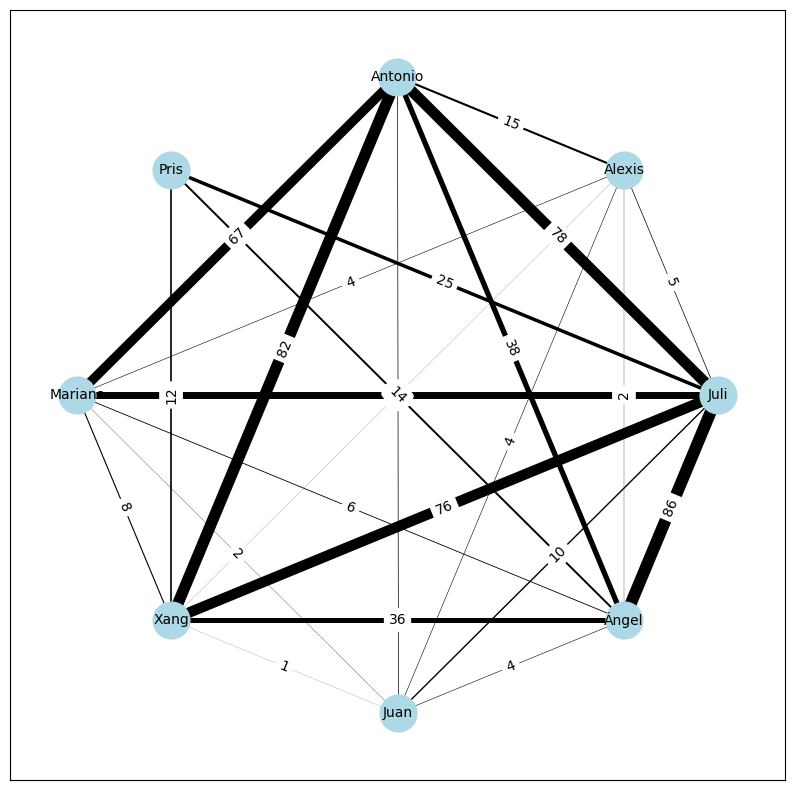

In [76]:
plt.figure(figsize=(10, 10))  # Set the size of the plot.

# Create a graph
G = nx.Graph()

# Add edges to the graphs with weights
for (user1, user2), songs in replaced_dict.items():
    if songs:
        G.add_edge(user1, user2, weight=len(songs))

# Define the position of nodes
pos = nx.circular_layout(G)
# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
# Draw node labels with specified font size
nx.draw_networkx_labels(G, pos, font_size=10)

# Calculate edge weights based on the number of mutual songs, adjusted by a scaling factor for visibility
weights = [G[u][v]['weight']*0.1 for u,v in G.edges()]
# Draw the edges using the calculated weights
nx.draw_networkx_edges(G, pos, width=weights)

# Get edge labels from the graph
labels = nx.get_edge_attributes(G, 'weight')
# Draw edge labels on the graph
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Display the graph
plt.show()

This graph can show us user preferences and behaviors, with this musical intersections between users, services can tailor their recommendations more effectively. Also, it can aid in community building, as users with similar tastes can be grouped together or introduced to each other.

## Conclusion
This tutorial has provided a comprehensive guide on using the Spotify API for social network analysis. We explored two types of networks: the Artist Collaboration Network and the User Song Sharing Network. Through these examples, we demonstrated how to authenticate with Spotify, fetch data using API calls, analyze and visualize complex networks to uncover relationships and patterns within data.

**You can do more...**
By leveraging the Spotify API, developers and data enthusiasts can create unique and powerful applications and insights, driving both user engagement and innovation in music technology. Whether you're building complex recommendation systems or simply exploring music data for insights, the Spotify API provides the tools necessary to dive deep into the world of music analytics.